In [1]:
from pathlib import Path
import numpy as np
import logging
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
)
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

In [2]:
import gammapy
gammapy.__version__

'2.0.dev2654+gde9547fe1.d20260122'

In [3]:
AMPLITUDE = 2.5e-10 * u.Unit("cm-2 s-1 TeV-1")
INDEX = 3.5
REF = 0.1 * u.TeV

# 10 % Crab
AMPLITUDE = 2.5e-12 * u.Unit("cm-2 s-1 TeV-1") 
INDEX = 2.6
REF = 1 * u.TeV

#ref based on crab fit (2.5e-11 at 1 TeV with index of 2.6) OK

#with 2.5e-10 at 0.1 TeV with index of 3.5 OK


In [4]:
path = Path("$GAMMAPY_DATA/CTA-prod5/CTA-Performance-prod5-v0.1-North-LSTSubArray-20deg.FITS/")
irf_filename = "Prod5-North-20deg-AverageAz-4LSTs.1800s-v0.1.fits.gz"

# telescope is pointing at a fixed position in ICRS for the observation
pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(0.0, 0.0, frame="galactic", unit="deg").icrs,
)
livetime = 0.5 * u.hr
location = observatory_locations["ctao_north"]


irfs = load_irf_dict_from_file(path / irf_filename)

In [5]:
observation = Observation.create(
    obs_id=1001,
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(observation)

Observation

	obs id            : 1001 
 	tstart            : 51544.00
	tstop             : 51544.02
	duration          : 1800.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [6]:
energy_axis = MapAxis.from_energy_bounds("0.01 TeV", "100 TeV", nbin=10, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.001 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
)
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,
    width=(2, 2),
    binsz=0.02,
    frame="galactic",
    axes=[energy_axis],
)

In [7]:
empty = MapDataset.create(
    geom,
    energy_axis_true=energy_axis_true,
    migra_axis=migra_axis,
    name="my-dataset",
)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Path("event_sampling_LST").mkdir(exist_ok=True)
dataset.write("./event_sampling_LST/dataset.fits", overwrite=True)

In [8]:
spectral_model_pwl = PowerLawSpectralModel(
    index=INDEX, amplitude=AMPLITUDE, reference=REF
)
spatial_model_point = PointSpatialModel(
    lon_0="0 deg", lat_0="0.5 deg", frame="galactic"
)

sky_model_pntpwl = SkyModel(
    spectral_model=spectral_model_pwl,
    spatial_model=spatial_model_point,
    name="point-pwl",
)

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

models = Models([sky_model_pntpwl, bkg_model])

file_model = "./event_sampling_LST/point-pwl.yaml"
models.write(file_model, overwrite=True)

In [9]:
dataset.models = models
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : point-pwl
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   2.50e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.500   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    tilt                  (frozen):      0.000                   
    norm                          :      1.000   +/-    0.00             
    reference             (frozen):      1.

In [10]:
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

2026-01-22 15:12:19,869 INFO Evaluating model: point-pwl
2026-01-22 15:12:20,402 INFO Evaluating background...
2026-01-22 15:12:23,405 INFO Event sampling completed.


In [11]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 1541
Background events: 191369


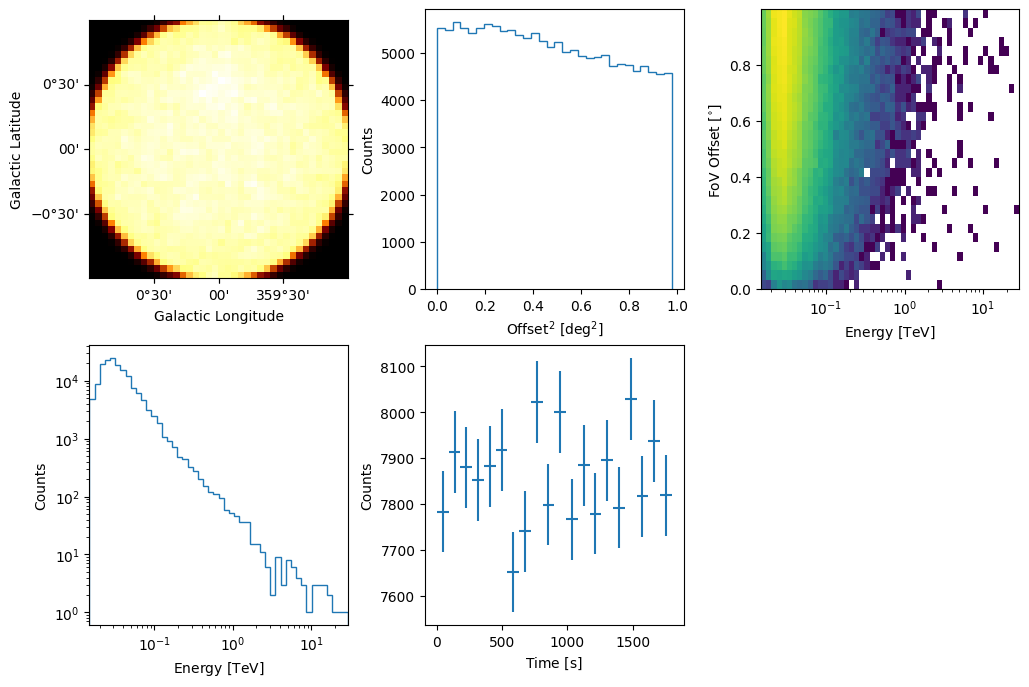

In [12]:
events.select_offset([0, 1] * u.deg).peek()
plt.show()

In [13]:
events.table.meta["OBJECT"] = dataset.models[0].name

In [14]:
observation.events = events
observation.write(
    "./event_sampling_LST/events_0001.fits", include_irfs=False, overwrite=True
)

In [15]:
observation = Observation.read(
    "./event_sampling_LST/events_0001.fits",
    irf_file = path / irf_filename)

# Running standard ON-OFF binned analysis

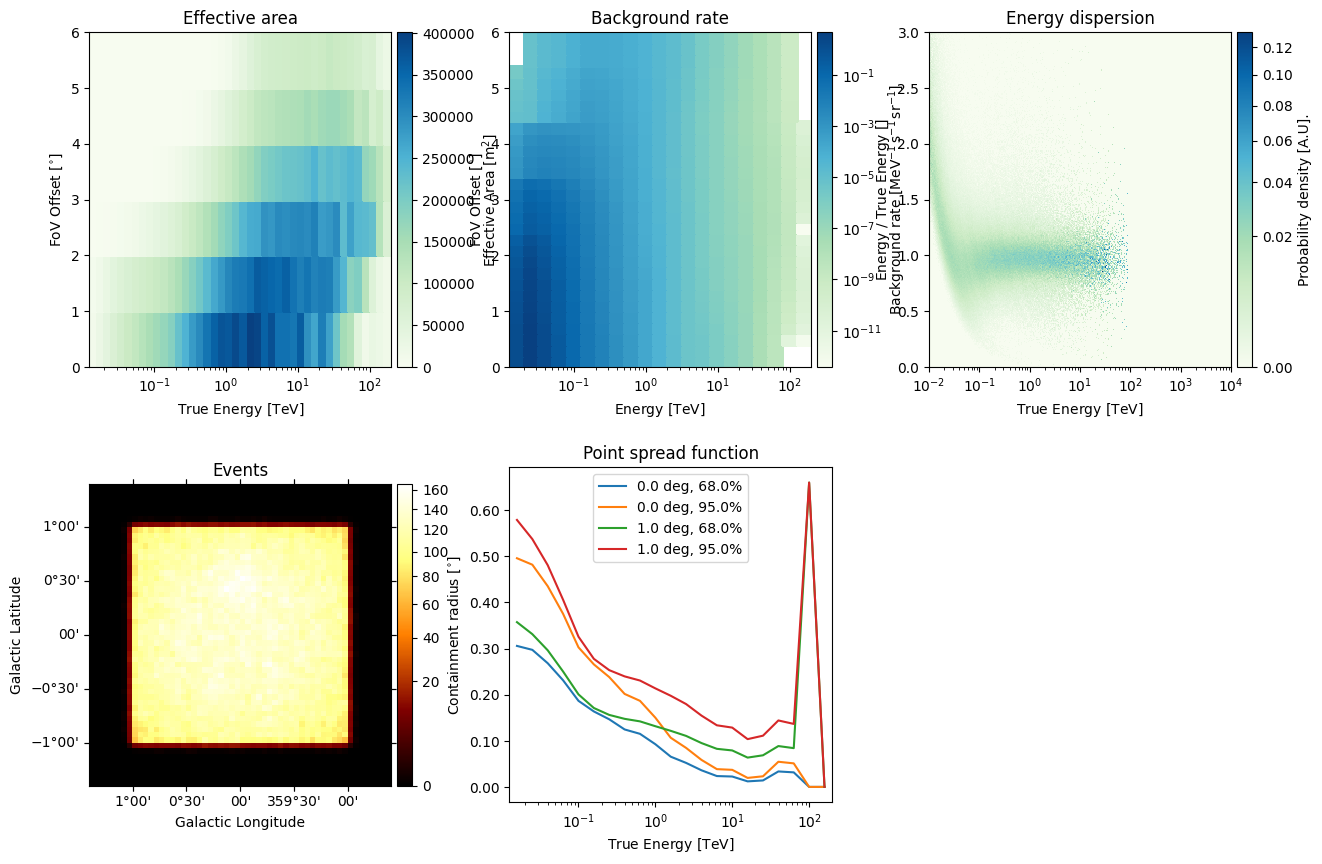

In [16]:
observation.peek()

In [17]:
from regions import  PointSkyRegion, CircleSkyRegion
from gammapy.maps import RegionGeom

from gammapy.datasets import (
    Datasets,
    MapDataset,
    MapDatasetOnOff,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from matplotlib.colors import LogNorm


from astropy.coordinates import AltAz, EarthLocation
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers import (
    FoVBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    MapDatasetMaker,
    WobbleRegionsFinder,
    ReflectedRegionsFinder
)
from gammapy.modeling import Fit

In [18]:
target_position = SkyCoord("0 deg","0.5 deg", frame="galactic")
on_region = CircleSkyRegion(center=target_position, radius=0.2*u.deg)

target_position.galactic


<SkyCoord (Galactic): (l, b) in deg
    (0., 0.5)>

In [19]:
energy_axis = MapAxis.from_energy_bounds(
    0.01, 100, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.005, 300, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
region_finder = WobbleRegionsFinder(
    n_off_regions=3
)

bkg_maker = ReflectedRegionsBackgroundMaker(
    region_finder=region_finder,
    exclusion_mask=None,
    #compute_acceptance=True,
    #background_normalisation_range=[0.3 * u.deg, 0.6 * u.deg], 
    )
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [20]:
datasets_std = Datasets()

dataset= dataset_maker.run(dataset_empty.copy(name=str(observation.obs_id)), observation)
dataset_on_off = bkg_maker.run(dataset, observation)
dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
datasets_std.append(dataset_on_off)
print(dataset_on_off)
print(datasets_std)

SpectrumDatasetOnOff
--------------------

  Name                            : 1001 

  Total counts                    : 5514 
  Total background counts         : 4749.33
  Total excess counts             : 764.67

  Predicted counts                : 4940.50
  Predicted background counts     : 4940.50
  Predicted excess counts         : nan

  Exposure min                    : 1.30e+07 m2 s
  Exposure max                    : 7.20e+08 m2 s

  Number of total bins            : 40 
  Number of fit bins              : 36 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 175.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 14248 
  Acceptance                      : 36 
  Acceptance off                  : 108 

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 1001
  Instrument : CTA
  Models     : 




In [21]:
#datasets_std[0].mask_safe = datasets_std[0]._geom.energy_mask(energy_min=0.1 * u.TeV)

In [22]:

reference=np.average(
        datasets_std[0].excess.geom.axes['energy'].center[datasets_std[0].mask.data.flatten()],
        weights=datasets_std[0].excess.data.flatten()[datasets_std[0].mask.data.flatten()])

log.info(f"Reference energy for fitting: {reference:.2f}")
spectral_model_fitter = PowerLawSpectralModel(
    index=3,
    amplitude=1e-12* u.Unit("cm-2 s-1 TeV-1"),
    reference=reference
)
    
skymodel = SkyModel(
    spectral_model=spectral_model_fitter.copy(),
    name="fit"
    )
skymodel.spectral_model.index.frozen = False

2026-01-22 15:12:33,541 INFO Reference energy for fitting: 0.14 TeV


In [23]:
datasets_std.models = [skymodel]
datasets_std[0]

In [24]:
fit = Fit()

result_binned = fit.run(datasets=datasets_std)
spectral_model_binned = datasets_std.models[0]
spectral_model_binned.parameters.to_table()

/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.3451e+00,,6.948e-02,nan,nan,False,,
,amplitude,3.3989e-10,TeV-1 s-1 cm-2,2.951e-11,nan,nan,False,,
,reference,1.3929e-01,TeV,0.000e+00,nan,nan,True,,


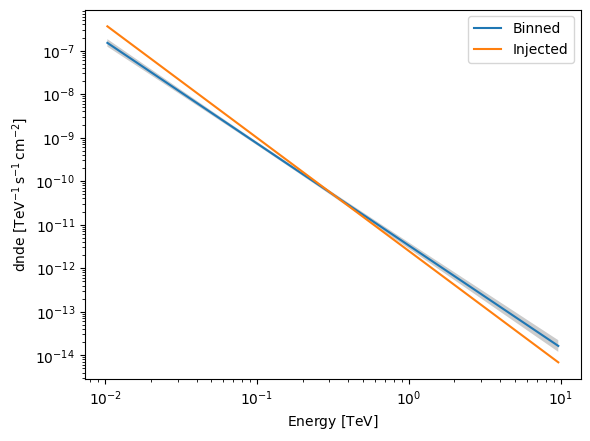

In [25]:
energy_bounds = [0.01, 10] * u.TeV
ax = spectral_model_binned.spectral_model.plot(energy_bounds=energy_bounds, label = 'Binned')
spectral_model_binned.spectral_model.plot_error(ax=ax,energy_bounds=energy_bounds)
spectral_model_pwl.plot(ax=ax, energy_bounds=energy_bounds, label = 'Injected')
plt.legend()

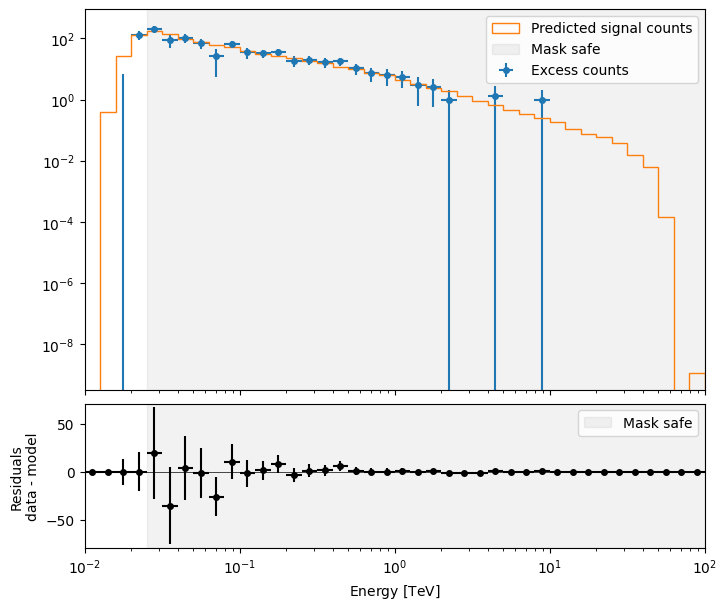

In [26]:
ax_spectrum, ax_residuals = datasets_std[0].plot_fit()
ax_spectrum.set_xlim(0.01, 100)
#ax_spectrum.set_ylim(1, 100)
plt.show()

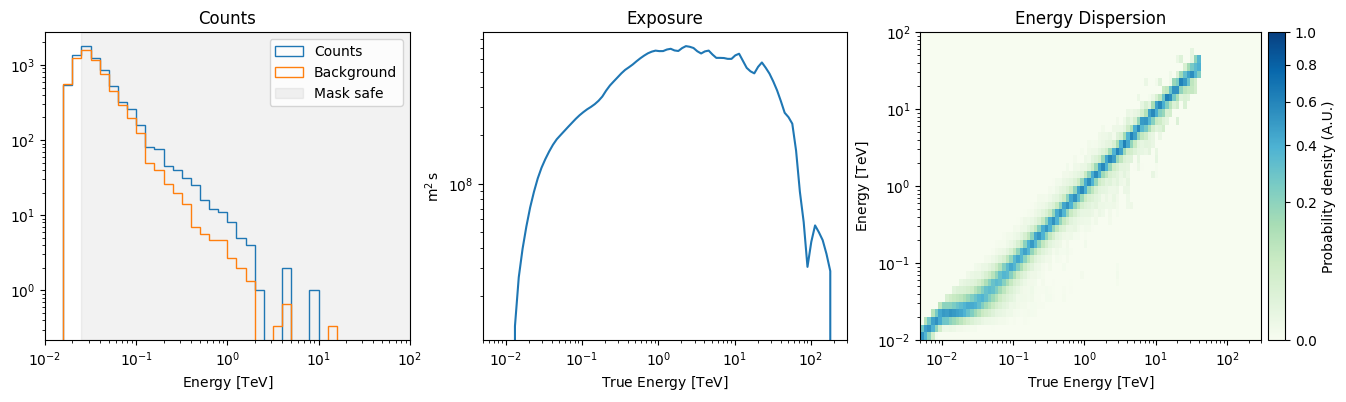

In [27]:
datasets_std[0].peek()

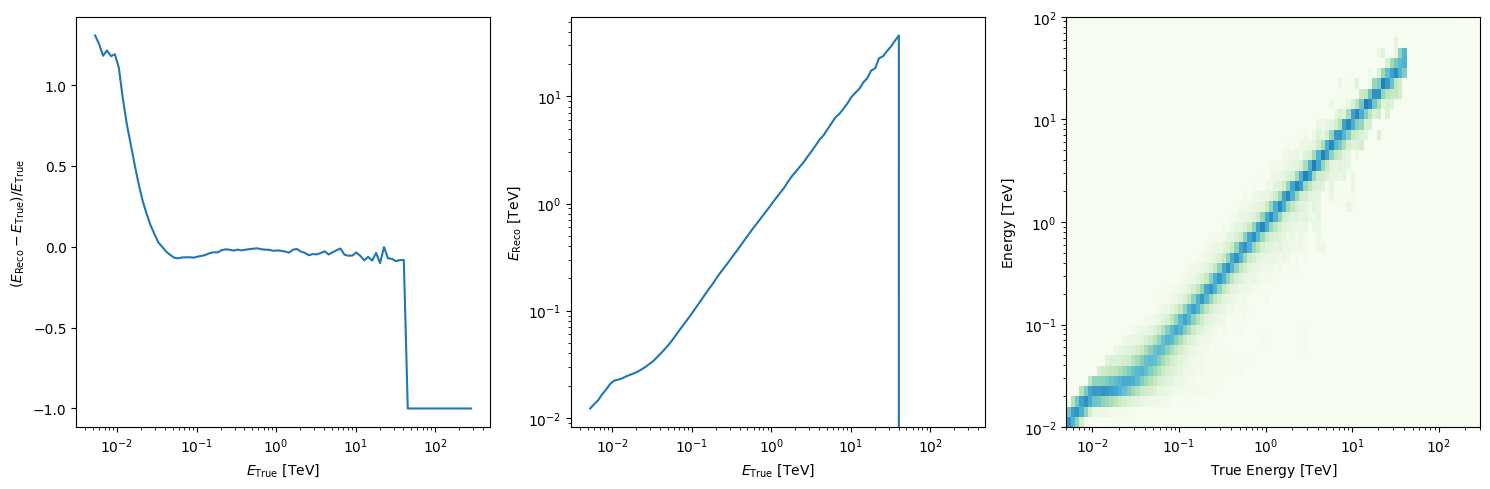

In [28]:
datasets_std[0].edisp.peek()

# Unbinned ON-OFF analysis

In [29]:
from gammapy.datasets import EventDataset
from gammapy.makers import EventDatasetMaker

In [30]:
energy_axis_true = MapAxis.from_energy_bounds(
    0.005, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region)#, axes=[energy_axis_true])

empty_dataset = EventDataset.create(
    geom=geom,
    name='simu',
    energy_axis_true=energy_axis_true,
)
dataset_maker = EventDatasetMaker(
    selection=["exposure", "edisp"],
    safe_mask_maker=None,
    # debug = True,
    normalize_edisp_from_data_energy_space=True,
)

region_finder = WobbleRegionsFinder(
    n_off_regions=3
)
bkg_maker = ReflectedRegionsBackgroundMaker(
    region_finder=region_finder,
    exclusion_mask=None,
    # compute_acceptance=True,
    # background_normalisation_range=[0.3 * u.deg, 0.6 * u.deg],
)
safe_mask_maker = SafeMaskMaker(
    methods=["aeff-max"], aeff_percent=10
    )



In [31]:
datasets_unbinned = Datasets()
dataset = dataset_maker.run(empty_dataset.copy(), observation)
dataset_on_off = bkg_maker.run(dataset, observation)
dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
datasets_unbinned.append(dataset_on_off)

/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in reciprocal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [32]:
skymodel = SkyModel(
    spectral_model=spectral_model_fitter.copy(),
    name="fit"
    )
skymodel.spectral_model.index.frozen = False
#skymodel.spectral_model.index.min = 1
models = Models(datasets_unbinned.models)
models.append(skymodel)
datasets_unbinned.models = models
print(datasets_unbinned)

Datasets
--------

Dataset 0: 

  Type       : EventDataset
  Name       : bRKAsmVb
  Instrument : CTA
  Models     : ['bRKAsmVb-bkg', 'fit']




In [33]:
datasets_unbinned.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str13
,norm,1.0000e+00,,0.000e+00,nan,nan,False,,GaussianPrior
,index,3.0000e+00,,0.000e+00,nan,nan,False,,
,amplitude,1.0000e-12,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,,
,reference,1.3929e-01,TeV,0.000e+00,nan,nan,True,,


In [34]:
datasets_unbinned[0].events_safe.energy.min()

<Quantity 0.02120477 TeV>

In [35]:
fit = Fit()

result_unbinned = fit.run(datasets=datasets_unbinned)
spectral_model_unbinned = datasets_unbinned.models['fit']


-2 * logL = [-34018.20195706]
mu_sig = [5.61391001], mu_bkg = [5656.8120473], n_on = 6532, n_off = 5658
-2 * logL = [-34081.64182978]
mu_sig = [5.61391001], mu_bkg = [6166.34714499], n_on = 6532, n_off = 5658
-2 * logL = [-33756.36751558]
mu_sig = [5.61391001], mu_bkg = [5147.27694962], n_on = 6532, n_off = 5658
-2 * logL = [-34032.88777846]
mu_sig = [5.61391001], mu_bkg = [5707.76555707], n_on = 6532, n_off = 5658
-2 * logL = [-34001.54016032]
mu_sig = [5.61391001], mu_bkg = [5605.85853754], n_on = 6532, n_off = 5658
-2 * logL = [-34018.35094207]
mu_sig = [6.3693046], mu_bkg = [5656.8120473], n_on = 6532, n_off = 5658
-2 * logL = [-34018.08238623]
mu_sig = [4.96877258], mu_bkg = [5656.8120473], n_on = 6532, n_off = 5658
-2 * logL = [-34018.30960296]
mu_sig = [6.16343951], mu_bkg = [5656.8120473], n_on = 6532, n_off = 5658
-2 * logL = [-34018.11052343]
mu_sig = [5.12514286], mu_bkg = [5656.8120473], n_on = 6532, n_off = 5658
-2 * logL = [-34018.39018658]
mu_sig = [6.11958072], mu_bkg =

In [36]:
datasets_unbinned.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str13
,norm,1.0009e+00,,9.810e-04,nan,nan,False,,GaussianPrior
,index,2.3703e+00,,5.984e-02,nan,nan,False,,
,amplitude,3.4650e-10,TeV-1 s-1 cm-2,2.604e-11,nan,nan,False,,
,reference,1.3929e-01,TeV,0.000e+00,nan,nan,True,,


In [37]:
datasets_std.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.3451e+00,,6.948e-02,nan,nan,False,,
,amplitude,3.3989e-10,TeV-1 s-1 cm-2,2.951e-11,nan,nan,False,,
,reference,1.3929e-01,TeV,0.000e+00,nan,nan,True,,


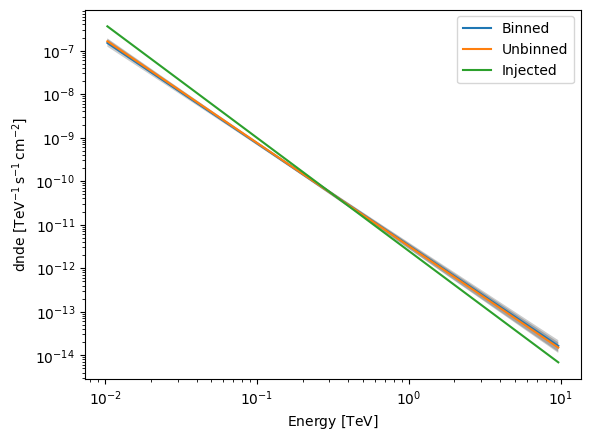

In [38]:
energy_bounds = [0.01, 10] * u.TeV
ax = spectral_model_binned.spectral_model.plot(energy_bounds=energy_bounds, label = 'Binned')
spectral_model_binned.spectral_model.plot_error(ax=ax,energy_bounds=energy_bounds)
spectral_model_unbinned.spectral_model.plot(ax=ax, energy_bounds=energy_bounds, label = 'Unbinned')
spectral_model_unbinned.spectral_model.plot_error(ax=ax,energy_bounds=energy_bounds)
spectral_model_pwl.plot(ax=ax, energy_bounds=energy_bounds, label = 'Injected')
plt.legend()

In [39]:
datasets_unbinned[0].background_model.norm.value

1.0009225089547336

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Model : fit'}, xlabel='Energy [$\\mathrm{TeV}$]'>)

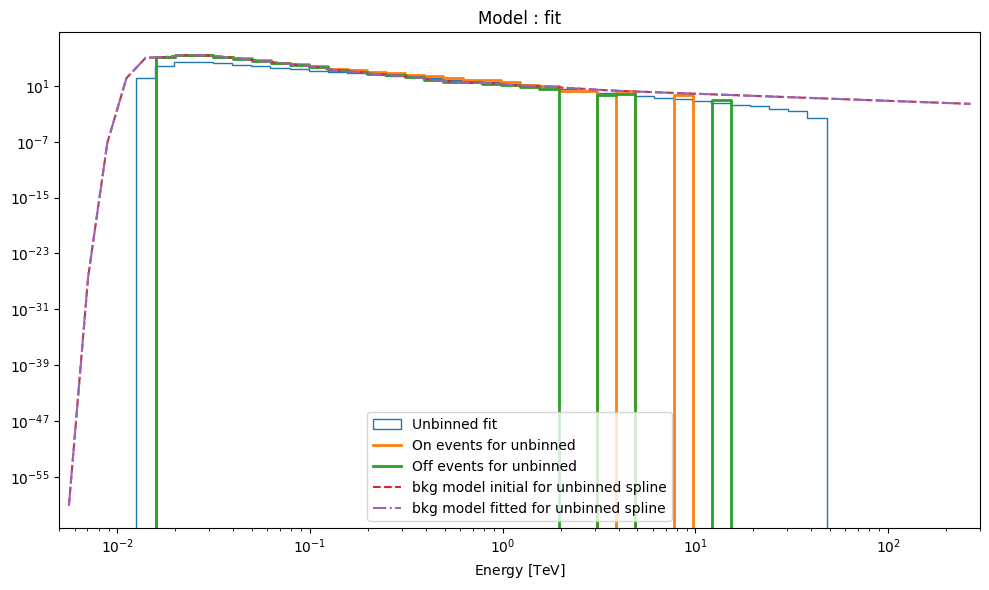

In [40]:
datasets_unbinned[0].plot_results()

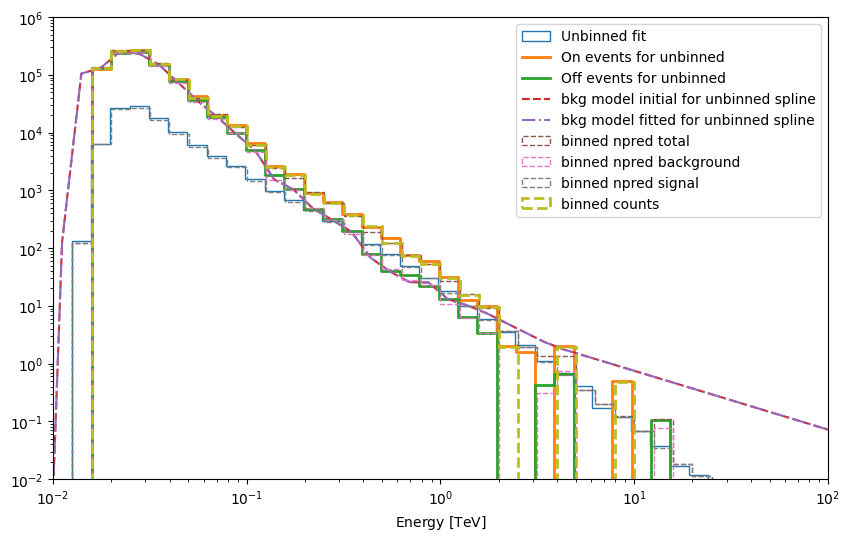

In [41]:
fig,ax = plt.subplots(figsize=(10,6))

_evaluator = datasets_unbinned[0].evaluators['fit']
flux = _evaluator.compute_flux()
flux = _evaluator.apply_exposure(flux)
flux = _evaluator.apply_edisp(flux,edisp=_evaluator.edisp_e_reco_binned)

flux.data = flux.data / flux.geom.axes['energy'].bin_width.value.reshape(-1,1,1)
ax = flux.plot_hist(ax=ax,label='Unbinned fit')

hist,_ =np.histogram(datasets_unbinned[0].events.energy,bins = flux.geom.axes['energy'].edges)
ax.plot(flux.geom.axes['energy'].center.value, hist / flux.geom.axes['energy'].bin_width, lw=2, label='On events for unbinned', drawstyle='steps-mid')


hist,_ =np.histogram(datasets_unbinned[0].events_off.energy,bins = flux.geom.axes['energy'].edges, weights=datasets_unbinned[0].alpha.data.flatten() if datasets_unbinned[0].alpha is not None else None)
ax.plot(flux.geom.axes['energy'].center.value, hist / flux.geom.axes['energy'].bin_width,drawstyle='steps-mid', lw=2, label='Off events for unbinned')

ax.plot(flux.geom.axes['energy'].center.value,1 / datasets_unbinned[0].background_model.norm.value * datasets_unbinned[0].background_model(flux.geom.axes['energy'].center), label='bkg model initial for unbinned spline', ls='--')

ax.plot(flux.geom.axes['energy'].center.value, datasets_unbinned[0].background_model(flux.geom.axes['energy'].center), label='bkg model fitted for unbinned spline', ls='-.')

flux_std = datasets_std[0].npred()
flux_std.data = flux_std.data / flux_std.geom.axes['energy'].bin_width.value.reshape(-1,1,1)
ax = flux_std.plot_hist(label='binned npred total', ls='--')

flux_bkg = datasets_std[0].npred_background()
flux_bkg.data = flux_bkg.data / flux_bkg.geom.axes['energy'].bin_width.value.reshape(-1,1,1)
ax = flux_bkg.plot_hist(label='binned npred background', ls='--')

flux_signal = datasets_std[0].npred_signal()
flux_signal.data = flux_signal.data / flux_signal.geom.axes['energy'].bin_width.value.reshape(-1,1,1)
ax = flux_signal.plot_hist(label='binned npred signal', ls='--')

counts_binned = datasets_std[0].counts.copy()
counts_binned.data = counts_binned.data / counts_binned.geom.axes['energy'].bin_width.value.reshape(-1,1,1)
ax = counts_binned.plot_hist(label='binned counts', ls='--', lw=2)


ax.set_xlim(0.01, 1e2)
ax.set_ylim(1e-2, 1e6)
ax.legend()

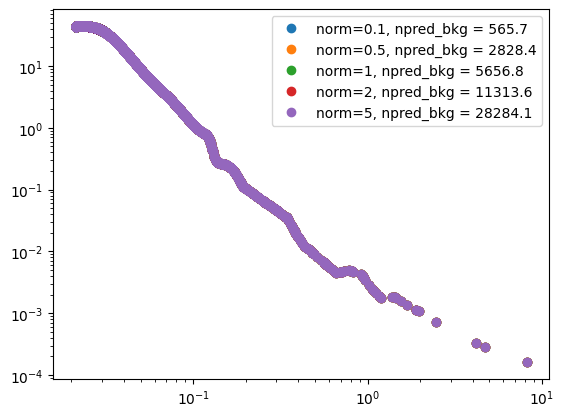

In [42]:
energy_min = datasets_unbinned[0].events_safe.energy.min()
energy_max = datasets_unbinned[0].events_safe.energy.max()
_norm = datasets_unbinned[0].background_model.norm.value
for norm in [0.1, 0.5, 1, 2, 5]:
    datasets_unbinned[0].background_model.norm.value = norm
    plt.loglog(
        datasets_unbinned[0].events_safe.energy,
        datasets_unbinned[0].background_pdf(energy_min=energy_min, energy_max=energy_max).data[datasets_unbinned[0].mask].flatten(),
        marker = 'o', linestyle = 'None', label=f'norm={norm}, npred_bkg = {datasets_unbinned[0].npred_background().data.sum():.1f}'
    )
plt.legend()
datasets_unbinned[0].background_model.norm.value = _norm


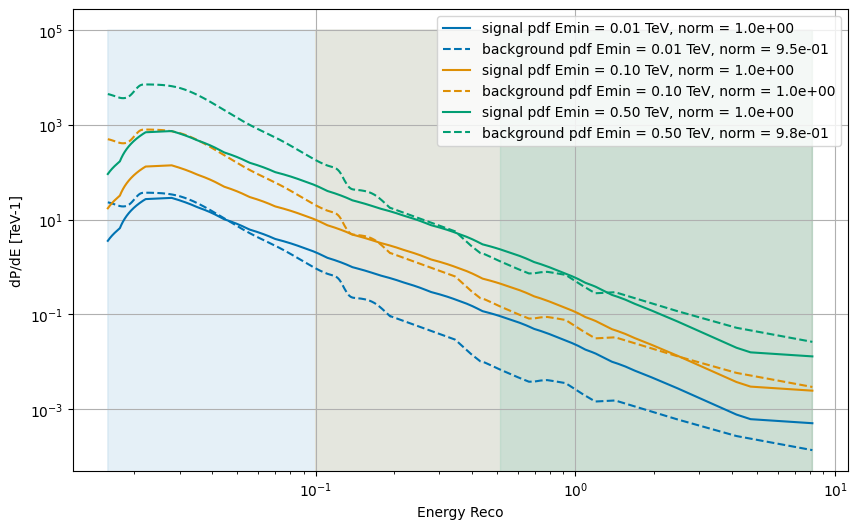

In [43]:
import seaborn as sns
from scipy.integrate import simpson
plt.figure(figsize=(10,6))
_energy = datasets_unbinned[0].geom.axes['energy'].center
argsort = np.argsort(_energy)
_energy = _energy[argsort]
colors = sns.color_palette("colorblind", 3)
for energy_min, color in zip([ 0.01, 0.1, 0.5] * u.TeV, colors):
    s = datasets_unbinned[0].signal_pdf(energy_min=energy_min,energy_max = None)
    b = datasets_unbinned[0].background_pdf(energy_min=energy_min,energy_max = None)
    _mask = _energy >= energy_min
    norm_s = simpson(s.data.flatten()[argsort][_mask], _energy[_mask])
    norm_b = simpson(b.data.flatten()[argsort][_mask], _energy[_mask])
    plt.loglog(_energy, s.data.flatten()[argsort], label='signal pdf Emin = {:.2f}, norm = {:.1e}'.format(energy_min, norm_s), color=color)
    plt.loglog(_energy, b.data.flatten()[argsort], label='background pdf Emin = {:.2f}, norm = {:.1e}'.format(energy_min, norm_b), color=color, ls='--')
    plt.fill_between(_energy[_mask].value, np.zeros(_energy[_mask].shape), 1e5 * np.ones(_energy[_mask].shape), color=color, alpha=0.1)
plt.xscale('log')
plt.yscale('log')

plt.legend(loc = 'upper right')
plt.xlabel("Energy Reco")
plt.ylabel("dP/dE [TeV-1]")
#plt.ylim(-0.1,1e7)
#plt.xlim(0.5e-1, 1e1)
plt.grid()

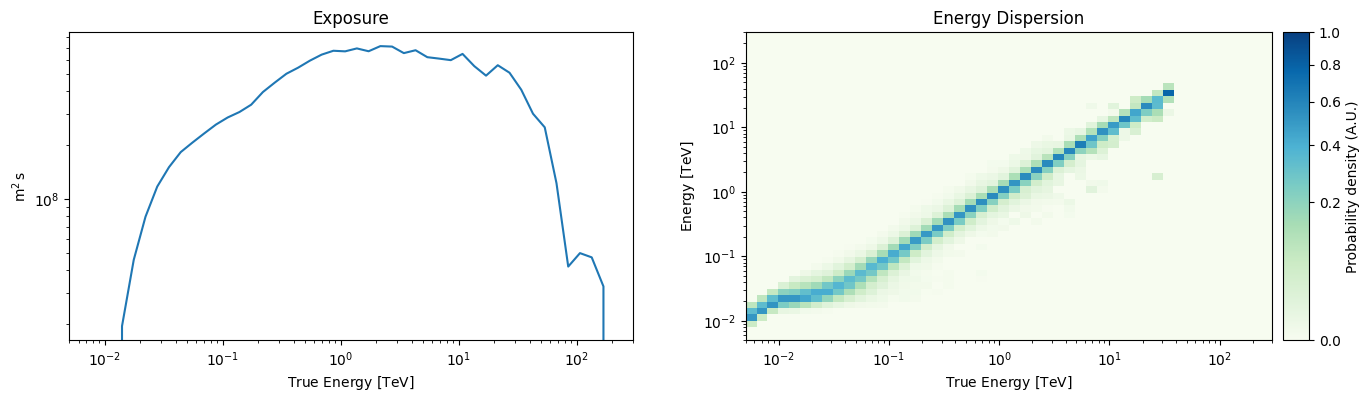

In [44]:
datasets_unbinned[0].peek()

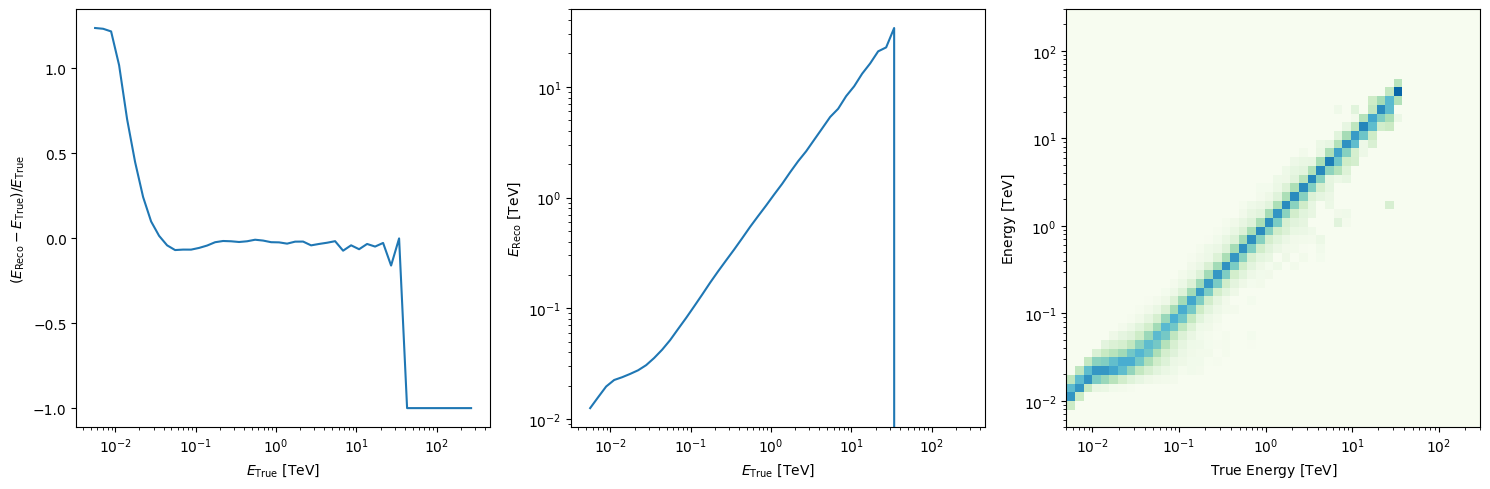

In [45]:
datasets_unbinned[0].edisp_e_reco_binned.peek()

2026-01-22 15:13:17,778 WARNING energy reco axis is un-binned, computation of mean energy reco from Edisp at energy true far for energies cover by events is not correct
2026-01-22 15:13:17,787 WARNING energy reco axis is un-binned, computation of mean energy reco from Edisp at energy true far for energies cover by events is not correct
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_411114/3841205473.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2+i].pcolormesh(
2026-01-22 15:13:17,830 WARNING energy reco axis is un-binned, computation of mean energy reco from Edisp at en

Emin = 0.01 TeV TeV
Emin = 0.10 TeV TeV


/tmp/ipykernel_411114/3841205473.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ax.legend()
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/grolleron/.local/opt/miniforge3/envs/gammapy-dev/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


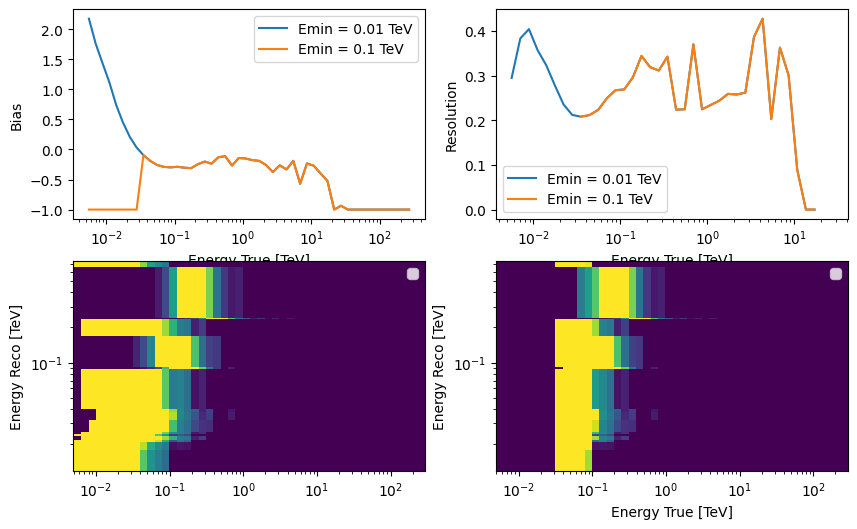

In [46]:
import copy
from matplotlib.colors import PowerNorm
_evaluator = datasets_unbinned[0].evaluators['fit']
fig,ax = plt.subplots(2,2,figsize=(10,6))
ax = ax.flatten()
etrue = _evaluator.edisp.axes['energy_true'].center
for i,energy in enumerate([0.01, 0.1] * u.TeV):
    print("Emin = {:.2f} TeV".format(energy))
    factor = _evaluator._get_factor_to_normalize_edisp(
        energy_min=energy, energy_max=100 * u.TeV
    )
    edisp = copy.deepcopy(_evaluator.edisp)
    edisp.quantity = factor[:, None] * _evaluator.edisp.quantity
    ax[0].plot(
        etrue,
        edisp.get_bias(
            etrue,
        ),
        label=f'Emin = {energy}'
    )
    ax[0].set_xlabel('Energy True [TeV]')
    ax[0].set_ylabel('Bias')
    ax[1].plot(
        etrue,
        edisp.get_resolution(
            etrue,
        ),
        label=f'Emin = {energy}'
    )
    ax[1].set_xlabel('Energy True [TeV]')
    ax[1].set_ylabel('Resolution')
    ax[2+i].pcolormesh(
        
        edisp.axes['energy_true'].center.value, edisp.axes['energy'].center.value[:1000], edisp.data.T[:1000], shading = 'nearest',norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
        )
    ax[2+1].set_xlabel('Energy True [TeV]')
    ax[2+i].set_ylabel('Energy Reco [TeV]')
    ax[2+i].set_yscale('log')
        
for _ax in ax :
    _ax.legend()
    _ax.set_xscale('log')

/tmp/ipykernel_411114/2241475546.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ax.legend()


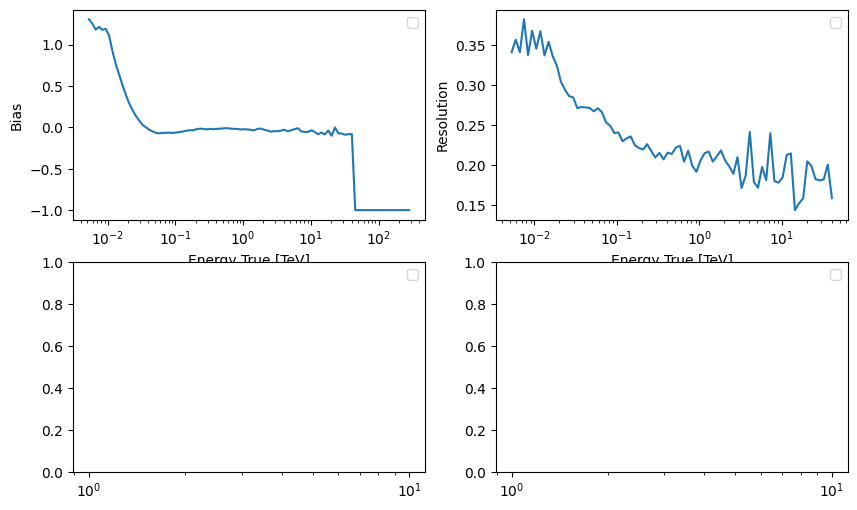

In [47]:
import copy
_evaluator = datasets_std[0].evaluators['fit']
fig,ax = plt.subplots(2,2,figsize=(10,6))
ax = ax.flatten()
etrue = _evaluator.edisp.axes['energy_true'].center
edisp = copy.deepcopy(_evaluator.edisp)
ax[0].plot(
    etrue,
    edisp.get_bias(
        etrue,
    ),
)
ax[0].set_xlabel('Energy True [TeV]')
ax[0].set_ylabel('Bias')
ax[1].plot(
    etrue,
    edisp.get_resolution(
        etrue,
    ),
)
ax[1].set_xlabel('Energy True [TeV]')
ax[1].set_ylabel('Resolution')
for _ax in ax :
    _ax.legend()
    _ax.set_xscale('log')

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Energy [$\\mathrm{TeV}$]'>

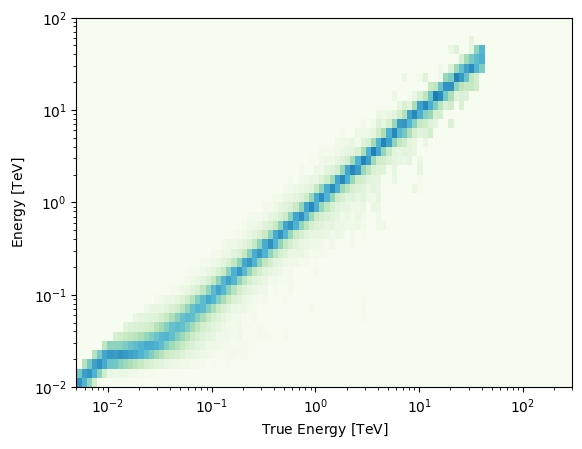

In [48]:
_evaluator.edisp.plot_matrix()